# Io AMI Image Deconvolution

In [1]:
import os
# os.chdir("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/amigo/src/amigo")

# autodiff
import jax
from jax import numpy as np
from zodiax.experimental import deserialise

# visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.transforms import Affine2D
import ehtplot
import scienceplots

# astronomy
import webbpsf

# optimisation
import optax

# AMIGO
import amigo
from amigo.files import get_files
from amigo.fisher import calc_fishers
from amigo.plotting import plot, plot_losses, summarise_fit

from optim_funcs import sgd, adam, simple_norm_fn, complex_norm_fn, grad_fn, loss_fn
from optim_funcs import L1_loss, L2_loss, TV_loss, ME_loss, QV_loss
# files
from zodiax.experimental import serialise, deserialise

plt.style.use(['science', 'bright', 'no-latex'])

# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 8

inferno = colormaps["inferno"]
viridis = colormaps["viridis"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
viridis.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

jax.config.update("jax_enable_x64", True)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


# Loading in Io Data
We have five Io exposures to load in, and four calibrator star exposures.

In [2]:
# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    # "/Users/mcha5804/JWST/ERS1373/calgrps/",
    "/Users/mcha5804/JWST/ERS1373/calslope_18/",
    "calslope",
    EXP_TYPE="NIS_AMI",
    FILTER=["F480M", "F430M", "F380M"],
    **kwargs
)

files = file_fn()

Here we can print out the shapes of the data, and we can see the calibrators have 12 groups and the Io exposures have 45 groups.

In [3]:
nsci = 3
sci_files = []

for file in files:
    if file[0].header["TARGPROP"] == "IO":
        sci_files.append(file)

temp_files = sci_files[:nsci]

for f in temp_files:
    print(f[0].header["TARGPROP"], f[0].header["NGROUPS"], f[1].data.shape)

# sci_files[0][0].header

IO 18 (17, 80, 80)
IO 18 (17, 80, 80)
IO 18 (17, 80, 80)


# Building the model

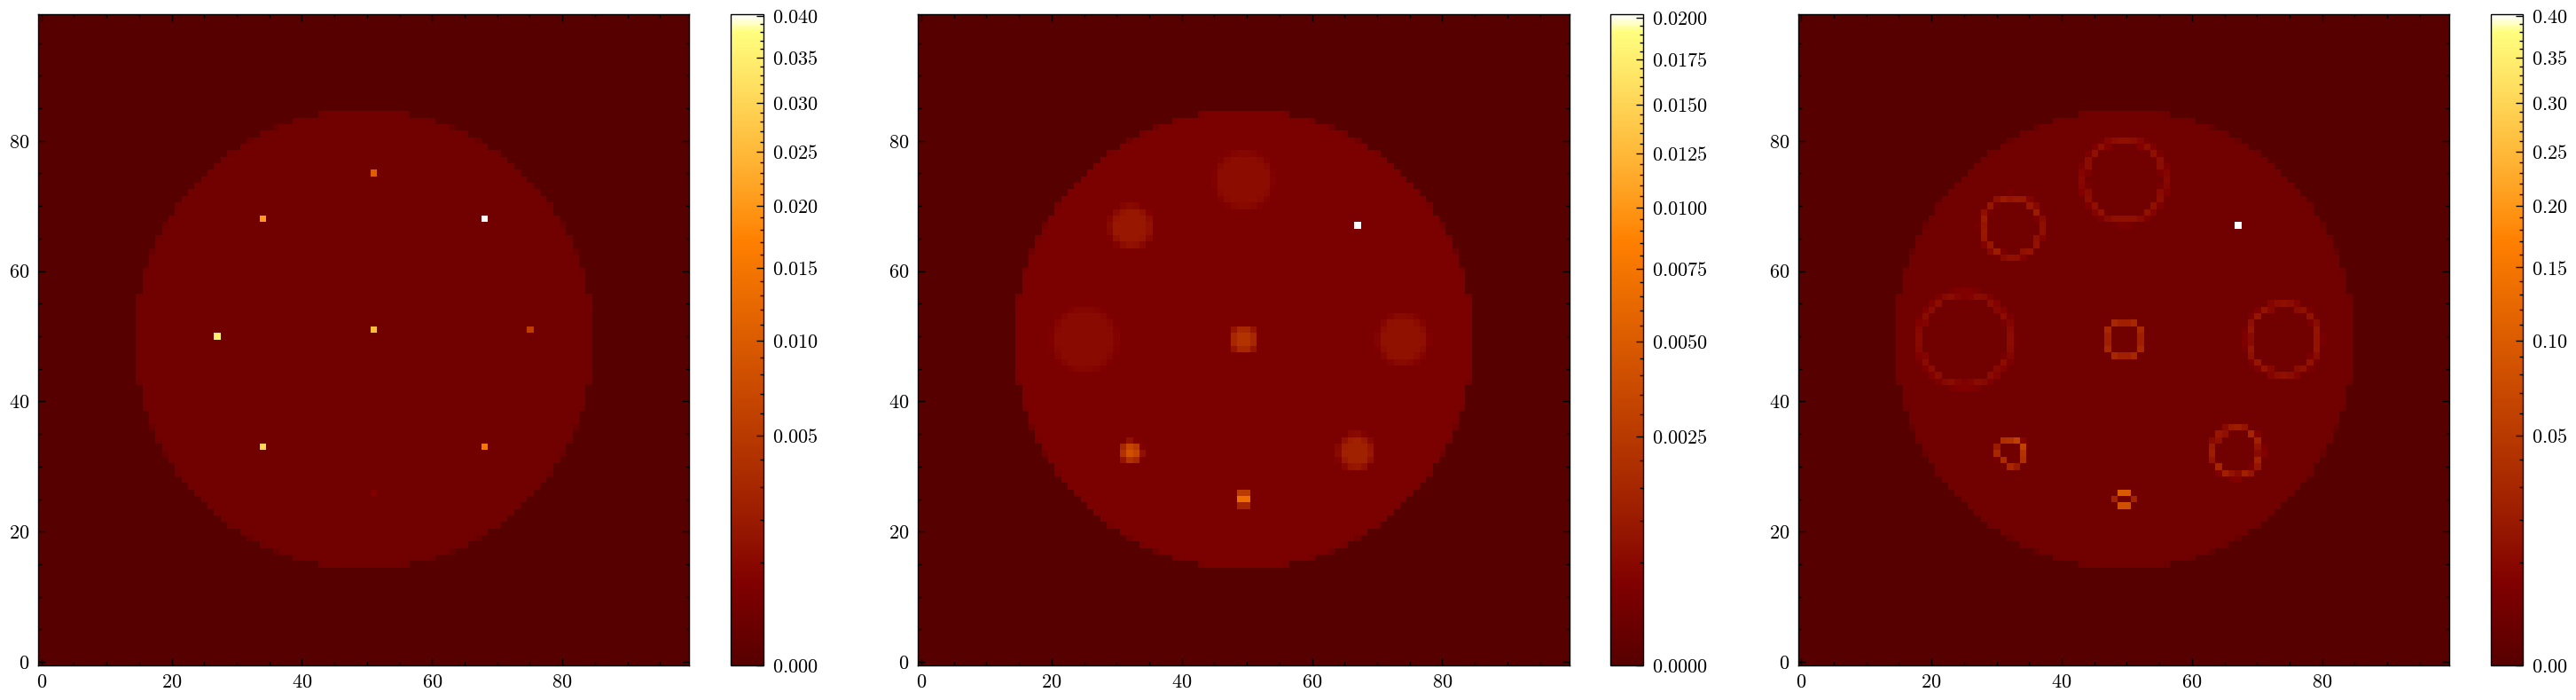

In [4]:
from amgio import build_model
import matplotlib as mpl

A = build_model.generate_dotted_disk()
B = build_model.generate_bloated_disk()
C = build_model.generate_ringed_disk()

source_distributions = [A, B, C]

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

c0 = ax[0].imshow(A, norm=mpl.colors.PowerNorm(0.5), cmap="afmhot_20u")
fig.colorbar(c0, ax=ax[0])

c1 = ax[1].imshow(B, norm=mpl.colors.PowerNorm(0.5), cmap="afmhot_20u")
fig.colorbar(c1, ax=ax[1])

c2 = ax[2].imshow(C, norm=mpl.colors.PowerNorm(0.5), cmap="afmhot_20u")
fig.colorbar(c2, ax=ax[2])

plt.tight_layout()
plt.show()

In [5]:
model_cache = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/"
initial_model, true_model, exposures = build_model.build_simulated_models(temp_files, model_cache)

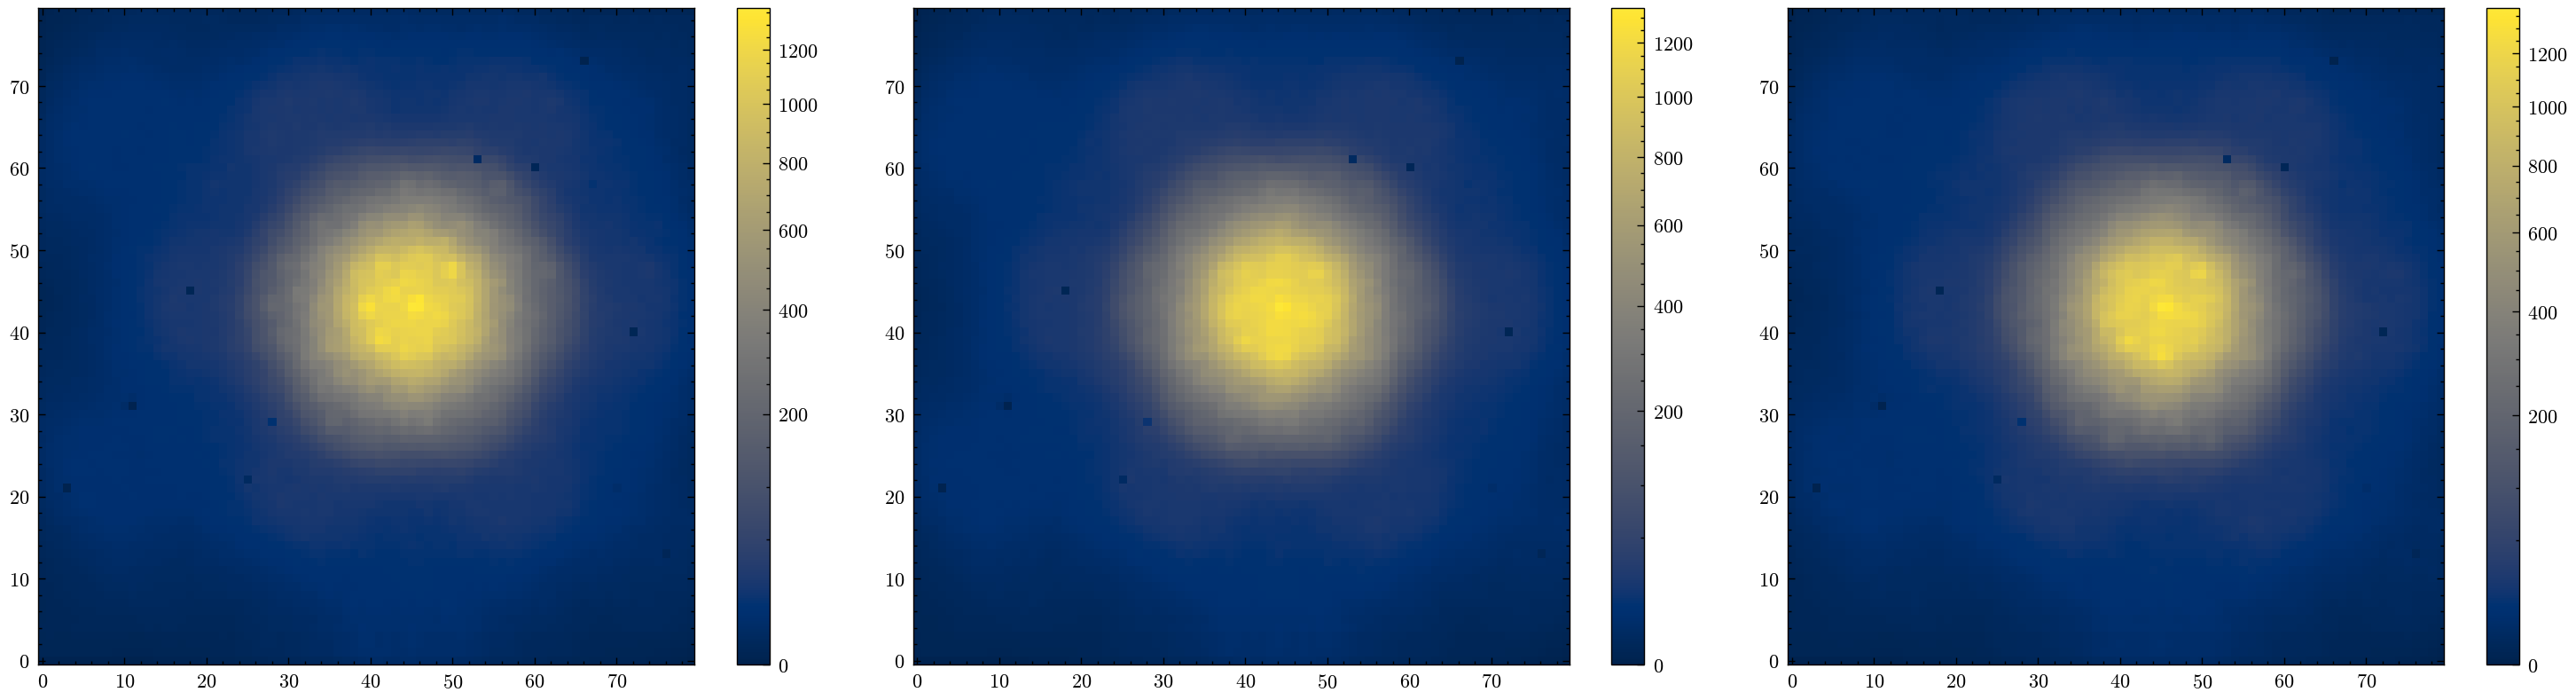

In [7]:
imgs = []
for exp in exposures:
    imgs.append(true_model.model(exp).mean(0))


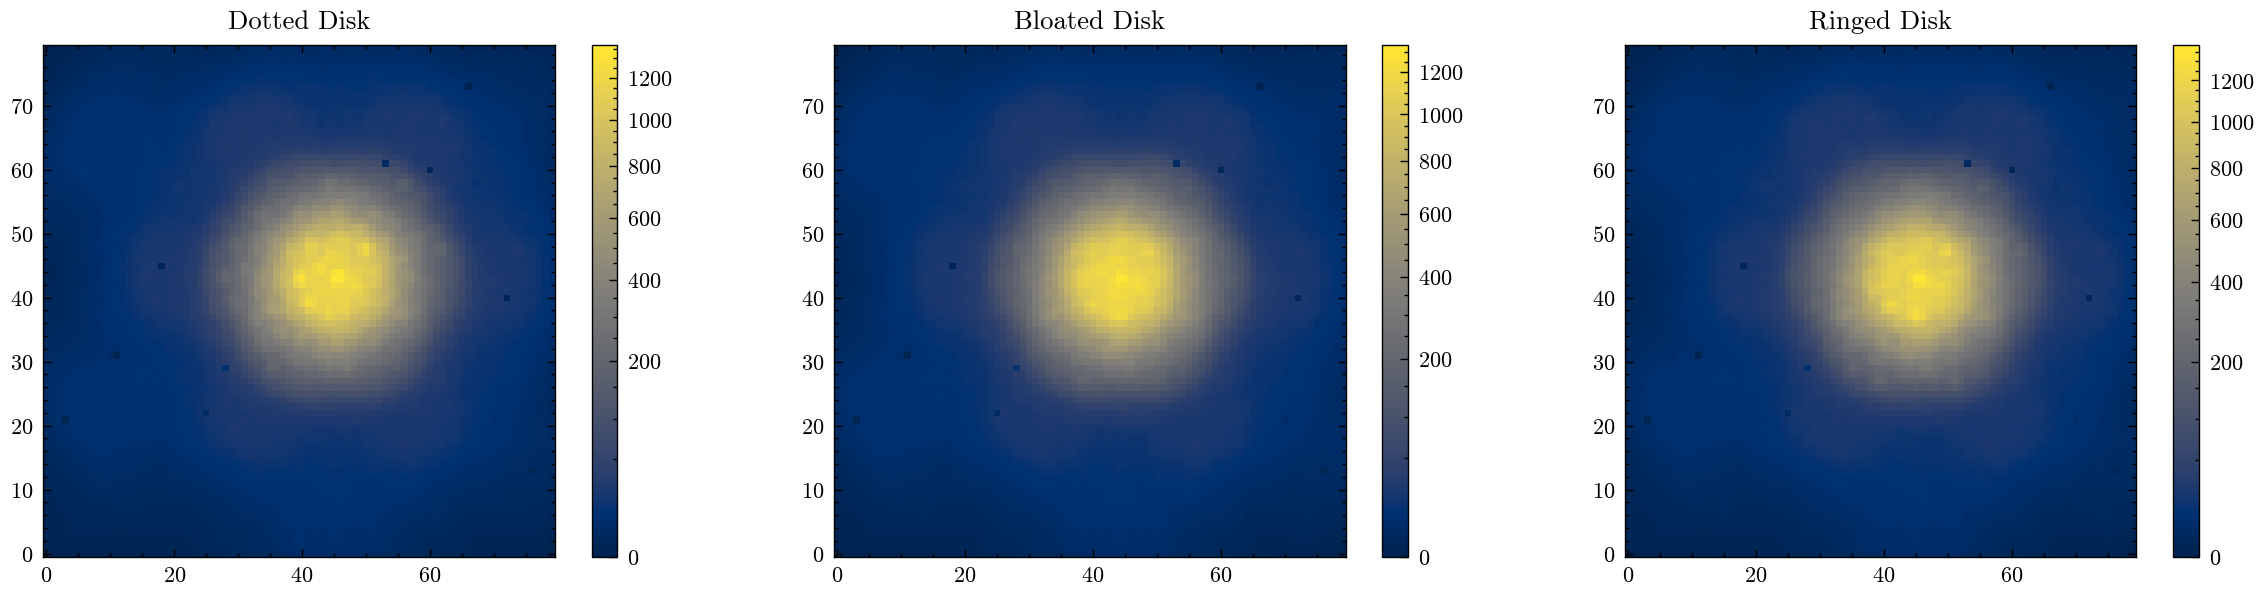

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

c0 = ax[0].imshow(imgs[0], norm=mpl.colors.PowerNorm(0.5), cmap="cividis")
ax[0].set(
    title="Dotted Disk",
)
fig.colorbar(c0, ax=ax[0])

c1 = ax[1].imshow(imgs[1], norm=mpl.colors.PowerNorm(0.5), cmap="cividis")
ax[1].set(
    title="Bloated Disk",
)
fig.colorbar(c1, ax=ax[1])

c2 = ax[2].imshow(imgs[2], norm=mpl.colors.PowerNorm(0.5), cmap="cividis")
ax[2].set(
    title="Ringed Disk",
)
fig.colorbar(c2, ax=ax[2])

plt.tight_layout()

plt.show()

Building initial model.

# Optimisation

In [9]:
sci_params = [
    # "positions",
    # "aberrations",
    "fluxes",
    # "one_on_fs",
    "log_distribution",
    # "source_spectrum.coefficients"
]
rampless_model = initial_model.set("ramp", None)
fishers = calc_fishers(rampless_model, exposures, sci_params)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
from amgio import stats

n_epoch = 20

reg_dict = {
    # "L1": 1.e0,
    # "L2": 1.e1,
    # "TV": 2.e1,
    # "QV": 3.e1,
    # "ME": 2e1, 
}

args = {
    "reg_dict": reg_dict,
    "reg_func_dict": stats.reg_func_dict,
    }

config = {
    # "positions": sgd(3e-1, 0),
    "fluxes": sgd(8e1, 0),
    "log_distribution": adam(2e-1, 3, (8, 0.3), b1=0.7),
    # "source_spectrum.coefficients": sgd(1e-1, 5),
    # "one_on_fs": sgd(1e-1, 9),
}

# running optimisation
final_model, losses, histories, states = amigo.fitting.optimise(
    initial_model,
    exposures,
    optimisers=config,
    fishers=fishers,
    loss_fn=stats.loss_fn,
    args=args,
    epochs=n_epoch,
    # grad_fn=grad_fn,
    print_grads=False,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Grad Batch fn compiling...
Compiling update function
Grad Batch fn compiling...
Grad Batch fn compiling...
Compiling update function
Compile Time: 0:00:41
Initial Loss: 155.48
Est time per epoch:  0:00:27
Est run remaining:  0:09:21


KeyboardInterrupt: 

In [31]:
true_model.filters["F430M"][0]

Array([4.12861111e-06, 4.16783333e-06, 4.20705556e-06, 4.24627778e-06,
       4.28550000e-06, 4.32472222e-06, 4.36394444e-06, 4.40316667e-06,
       4.44238889e-06], dtype=float64)

In [32]:
from jax import scipy as jsp


def get_diffraction_limit(model):
    """
    Returns the diffraction limit in arcseconds.
    """
    effective_wl = np.dot(
        model.filters["F430M"][0], model.filters["F430M"][1]
    )
    return dlu.rad2arcsec(effective_wl / model.optics.diameter)

def diff_lim_to_cov(model):
    diff_lim = get_diffraction_limit(model)
    sigma = 1.025 / (2 * np.sqrt(2 * np.log(2))) * diff_lim
    return [[sigma**2, 0], [0, sigma**2]]


def get_pscale(model):
    return model.optics.psf_pixel_scale / model.optics.oversample

def blur_distribution(model, exposure, extent=0.15):
    cov = diff_lim_to_cov(model)

    x = np.arange(-extent, extent, get_pscale(model))
    X, Y = np.meshgrid(x, x)
    pos = np.dstack((X, Y))

    kernel = jsp.stats.multivariate_normal.pdf(jr.PRNGKey(0), pos, np.array(cov))

    distribution = jsp.signal.convolve2d(model.distribution(exposure), kernel, mode="same")
    return distribution / distribution.sum()


def get_loglike_map(true_model, final_model, exposure, blur: bool = False, std_min: int = 100):
    flux = 10 ** true_model.params["fluxes"]["IO_F430M"]

    if blur:
        truth = flux * blur_distribution(true_model, exposure)
    else:
        truth = flux * true_model.distribution(exposure)
    recovered = flux * final_model.distribution(exposure)
    std = np.maximum(np.sqrt(truth), std_min)

    return -jax.scipy.stats.norm.logpdf(truth, recovered, std)

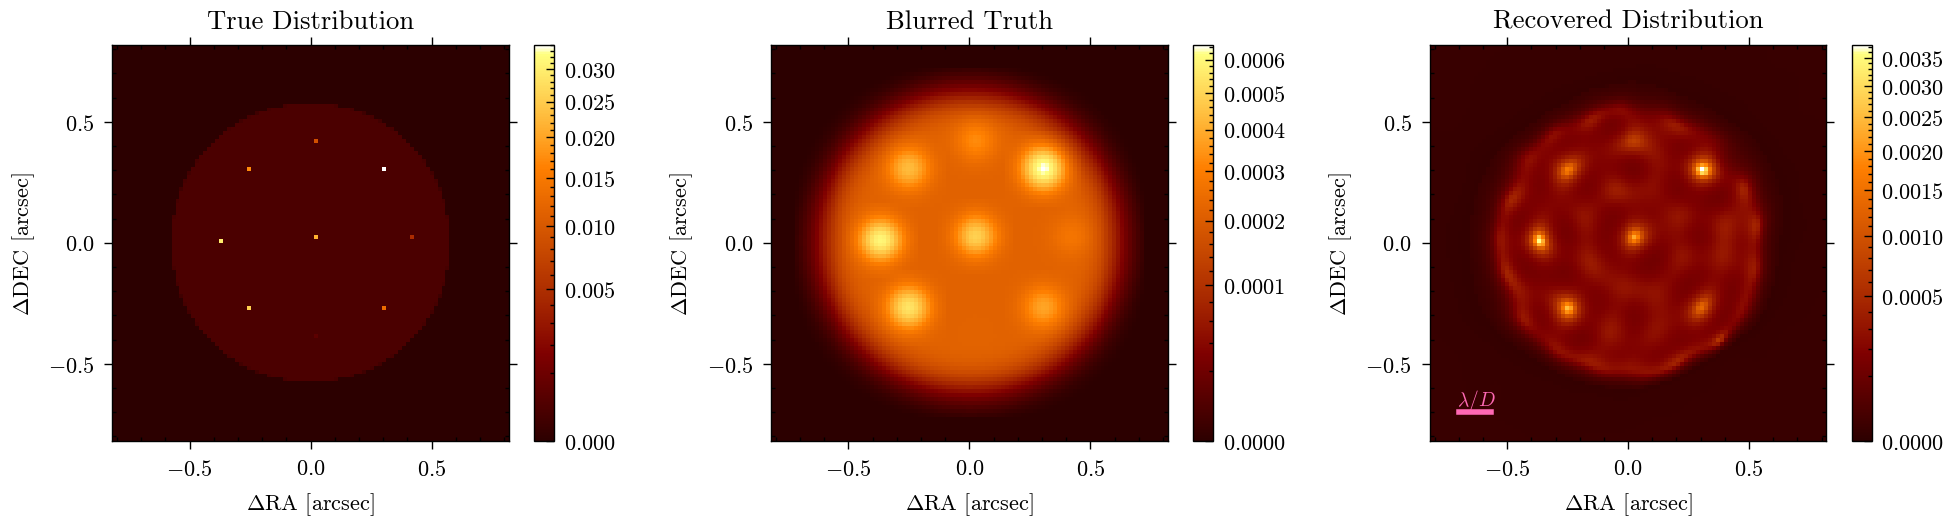

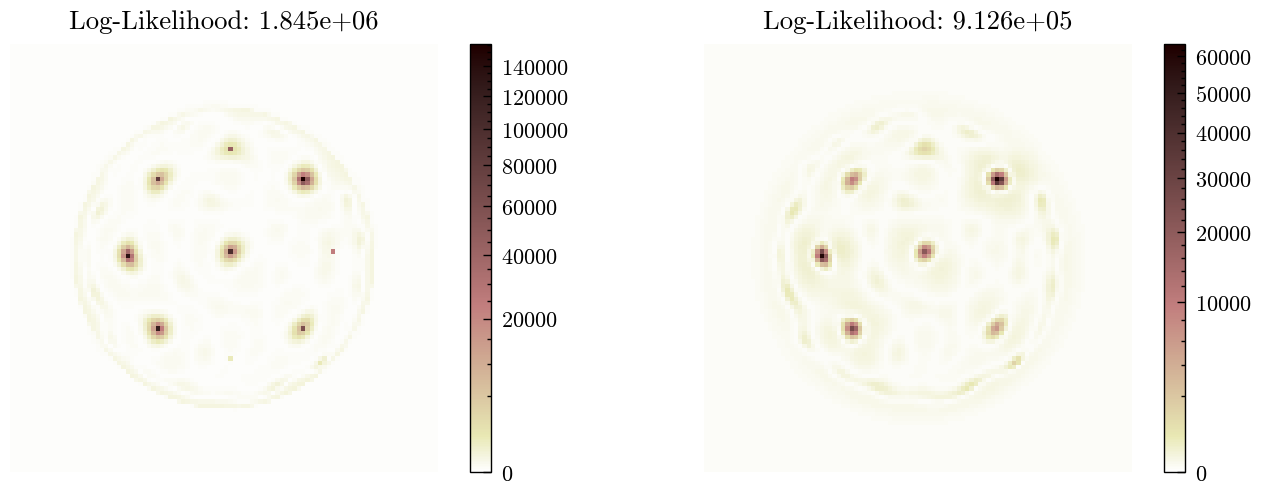

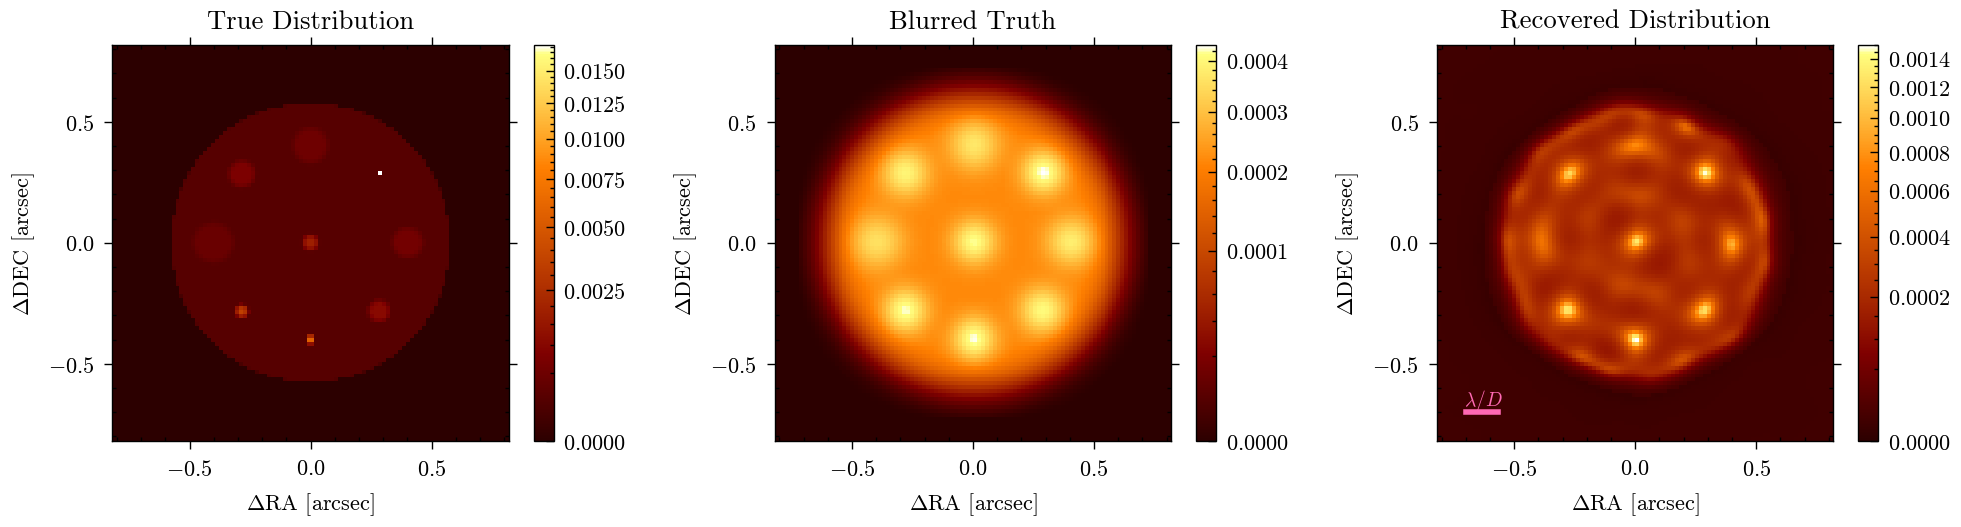

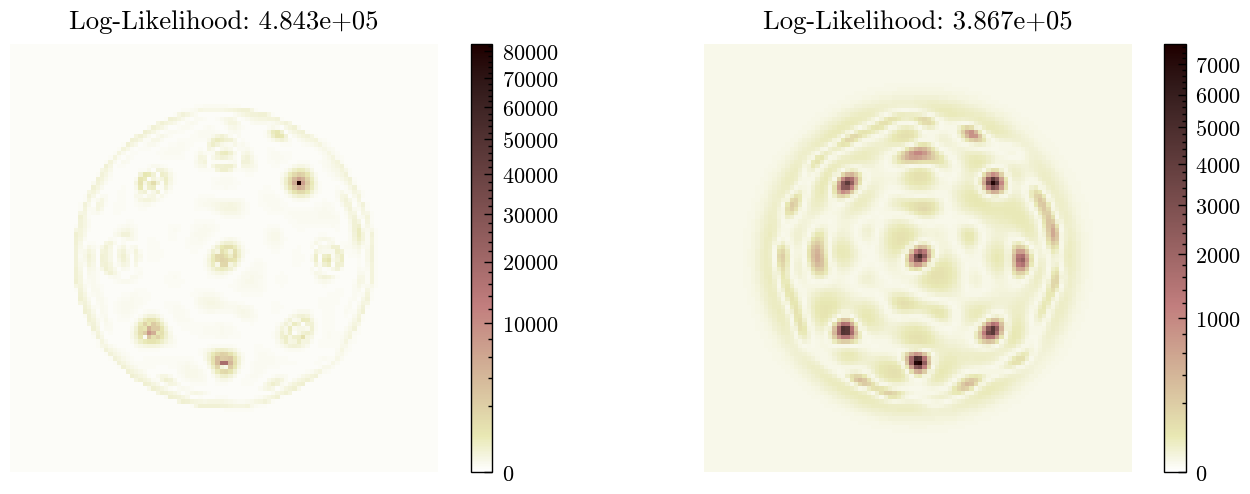

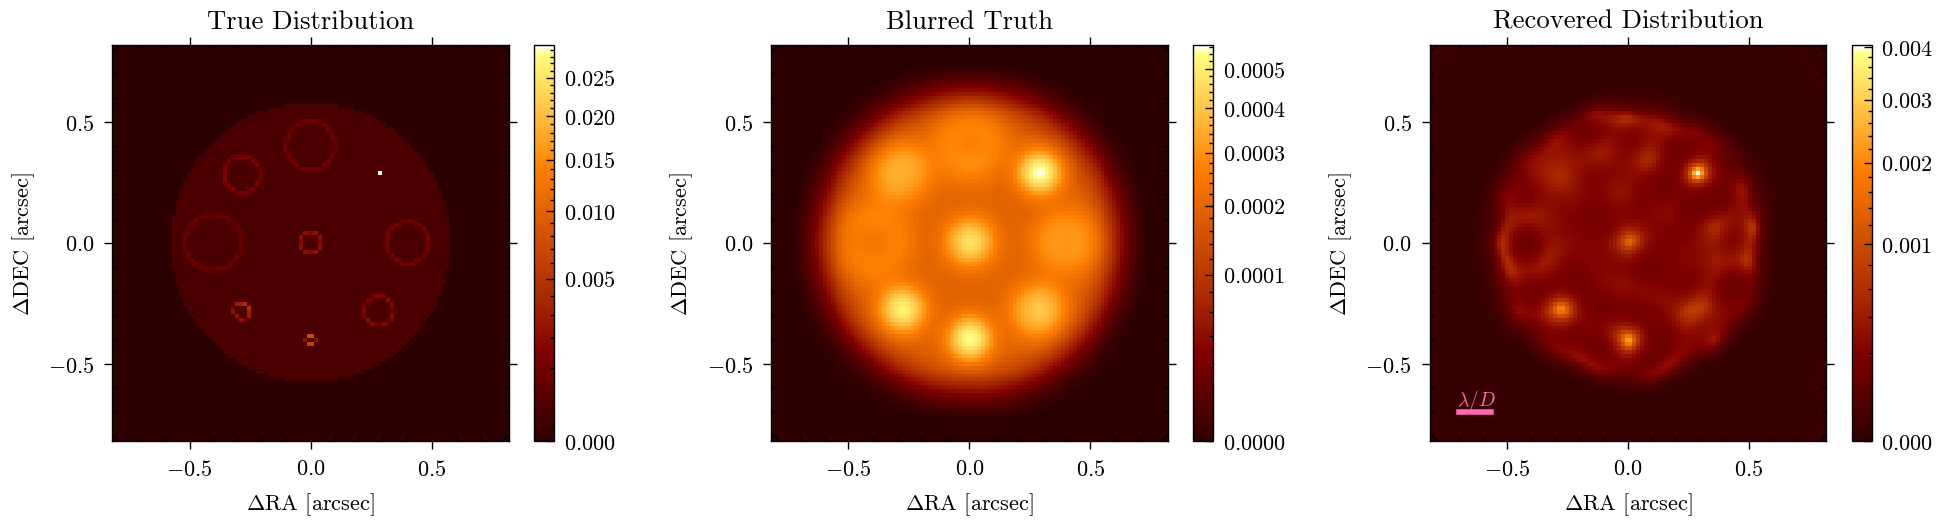

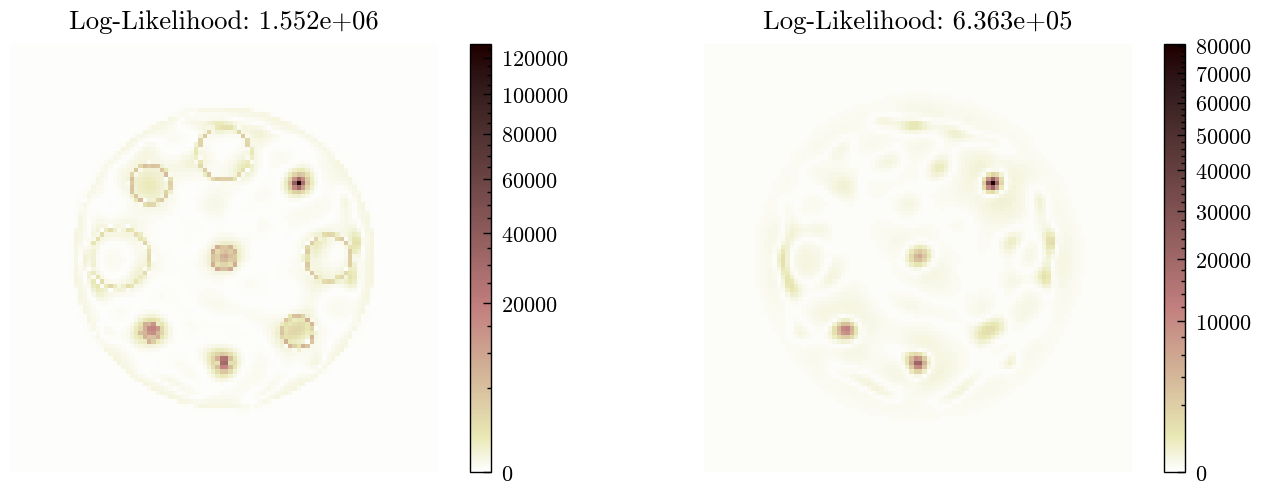

In [37]:
# %matplotlib qt
import matplotlib as mpl
from amgio import plotting


for exp in exposures:

    llm = get_loglike_map(true_model, final_model, exp, blur=False)
    bllm = get_loglike_map(true_model, final_model, exp, blur=True)

    fig, ax = plt.subplots(1, 3, figsize=(10, 2.6))

    ax[0].set(
        title="True Distribution",
    )
    im0 = plotting.plot_io(
        ax[0],
        true_model.distribution(exp),
        model=true_model,
        show_diff_lim=False,
    )
    fig.colorbar(im0, ax=ax[0])

    ax[1].set(
        title="Blurred Truth",
    )
    im1 = plotting.plot_io(
        ax[1],
        blur_distribution(true_model, exp),
        model=true_model,
        show_diff_lim=False,
    )
    fig.colorbar(im1, ax=ax[1])

    ax[2].set(
        title="Recovered Distribution",
    )
    im2 = plotting.plot_io(
        ax[2],
        final_model.distribution(exp),
        model=final_model,
    )
    fig.colorbar(im2, ax=ax[2])

    plt.tight_layout()
    plt.show()


    fig, ax = plt.subplots(1, 2, figsize=(7, 2.6))

    im0 = ax[0].imshow(llm, norm=mpl.colors.PowerNorm(0.5, vmin=0), cmap="pink_ur")
    ax[0].set(
        title=f"Log-Likelihood: {llm.sum():.3e}",
    )
    ax[0].axis("off")
    fig.colorbar(im0, ax=ax[0])

    im1 = ax[1].imshow(bllm, norm=mpl.colors.PowerNorm(0.5, vmin=0), cmap="pink_ur")
    ax[1].set(
        title=f"Log-Likelihood: {bllm.sum():.3e}",
    )
    ax[1].axis("off")
    fig.colorbar(im1, ax=ax[1])

    plt.tight_layout()
    plt.show()


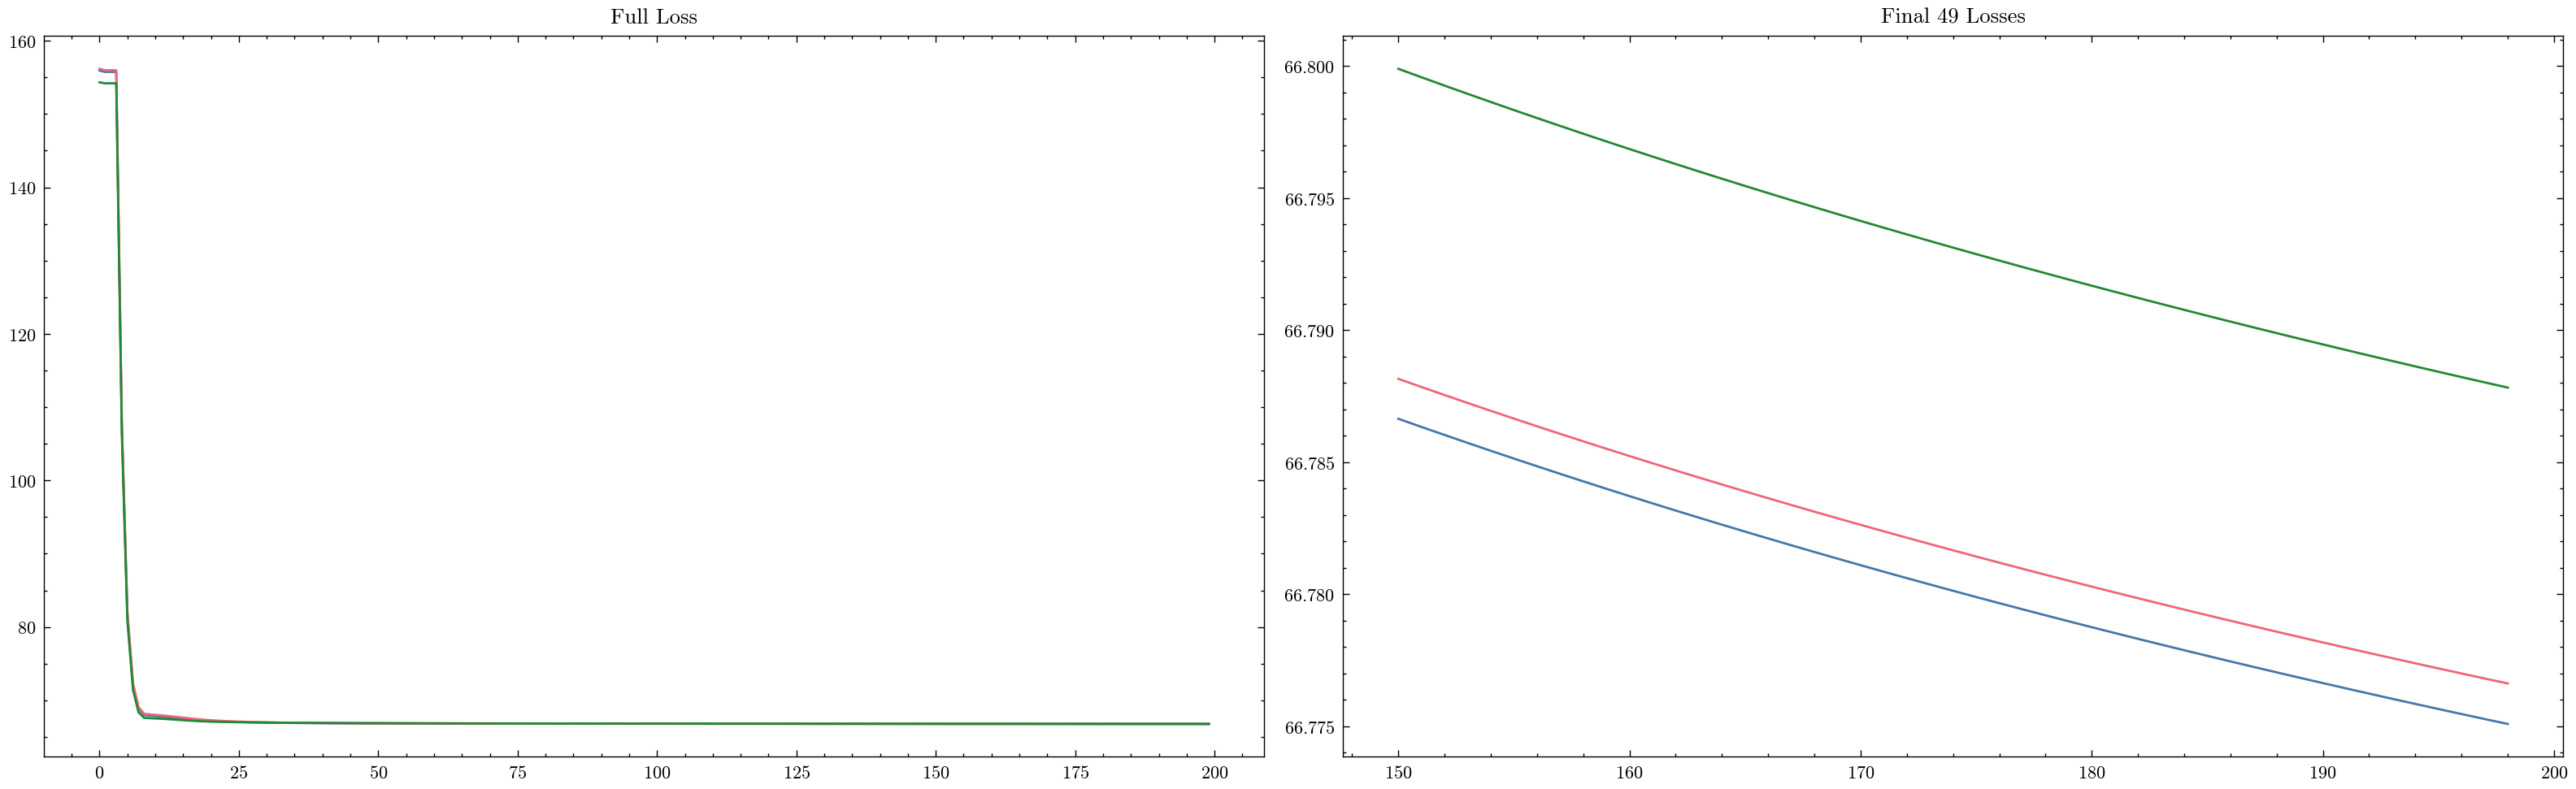

No formatting function for log_distribution
No formatting function for log_distribution
No formatting function for log_distribution


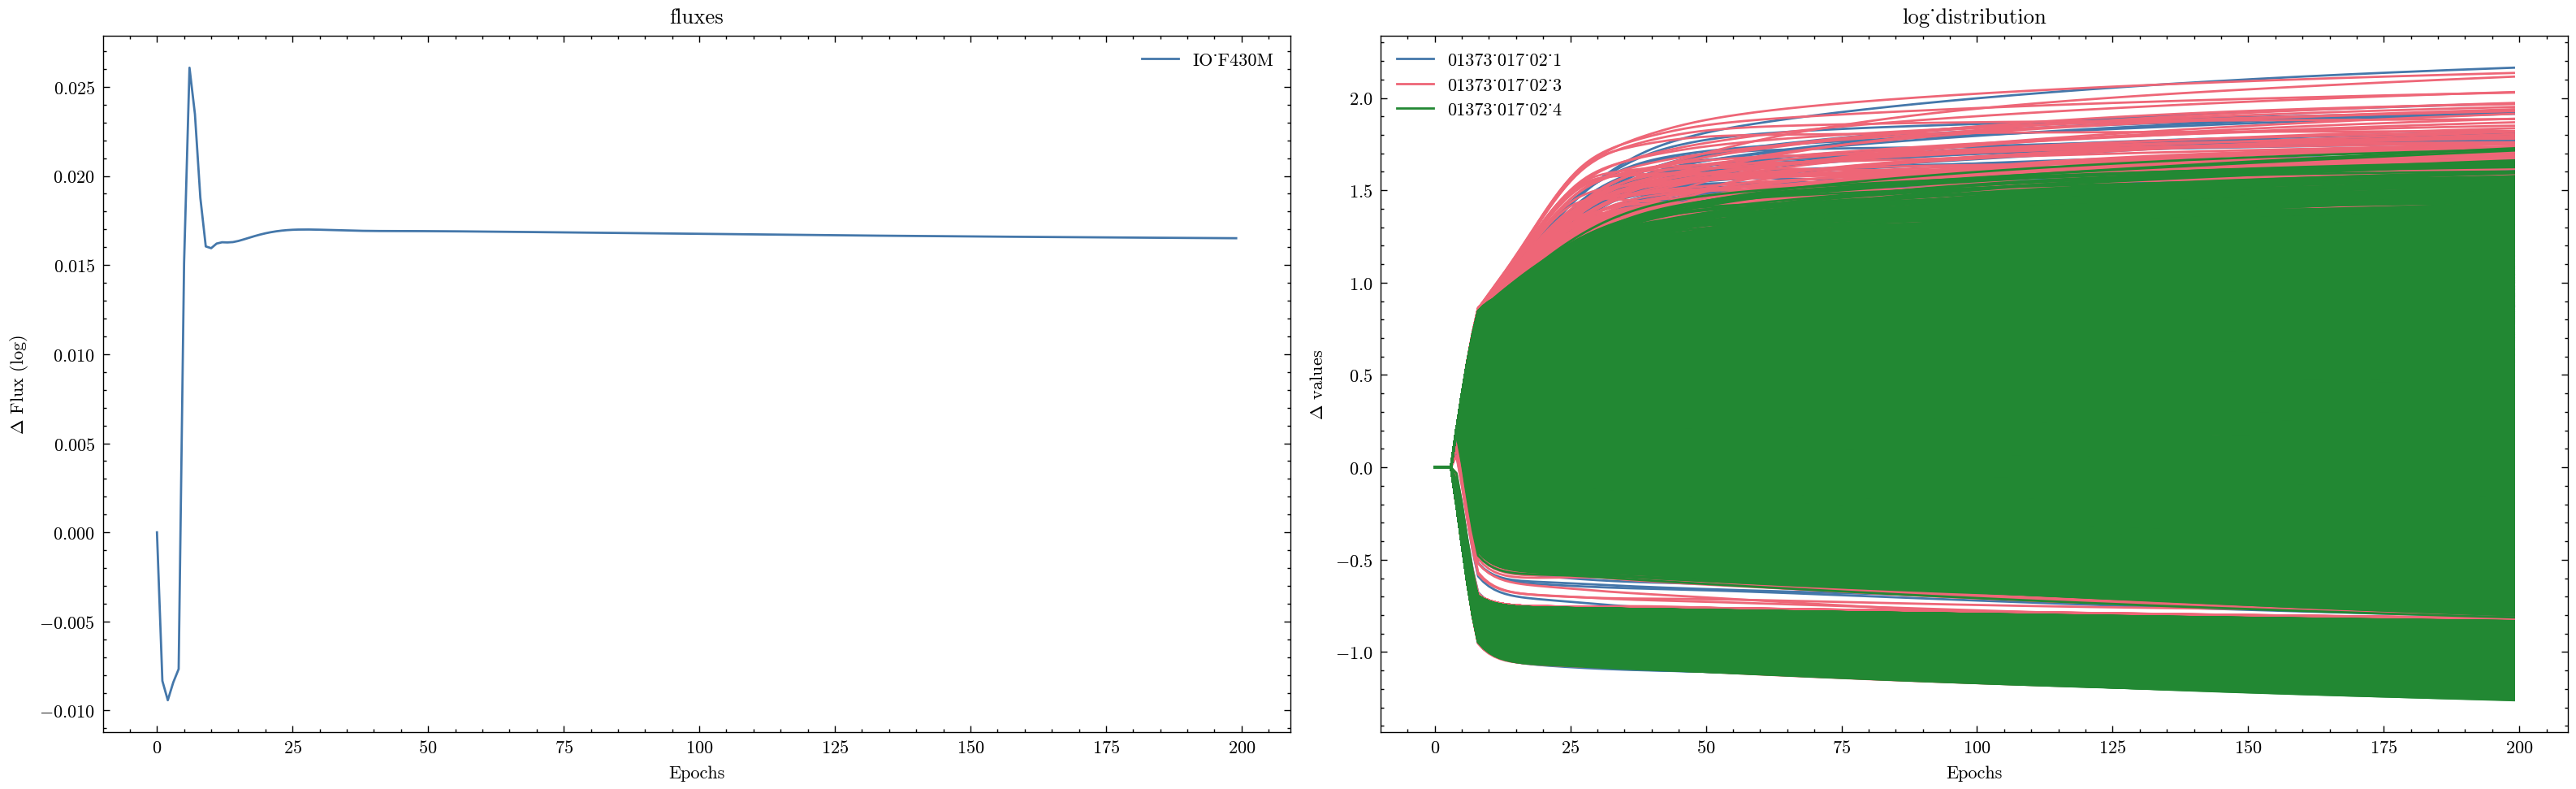

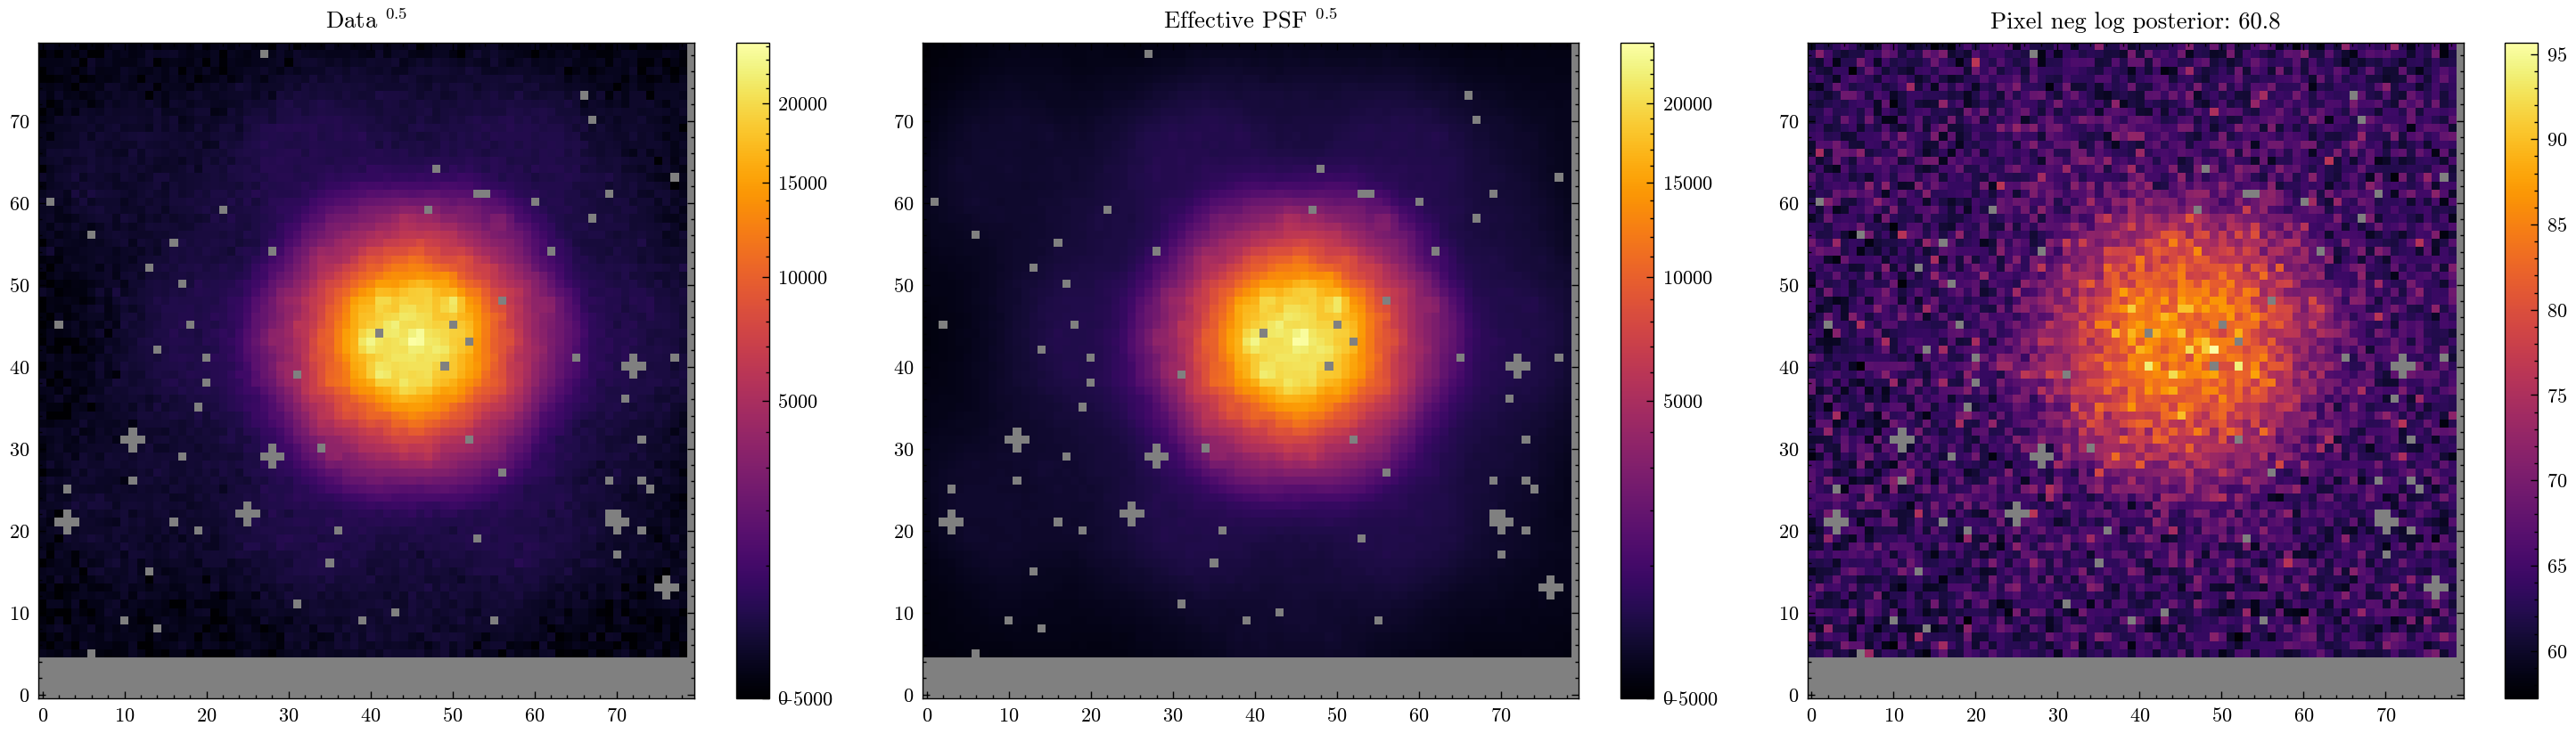

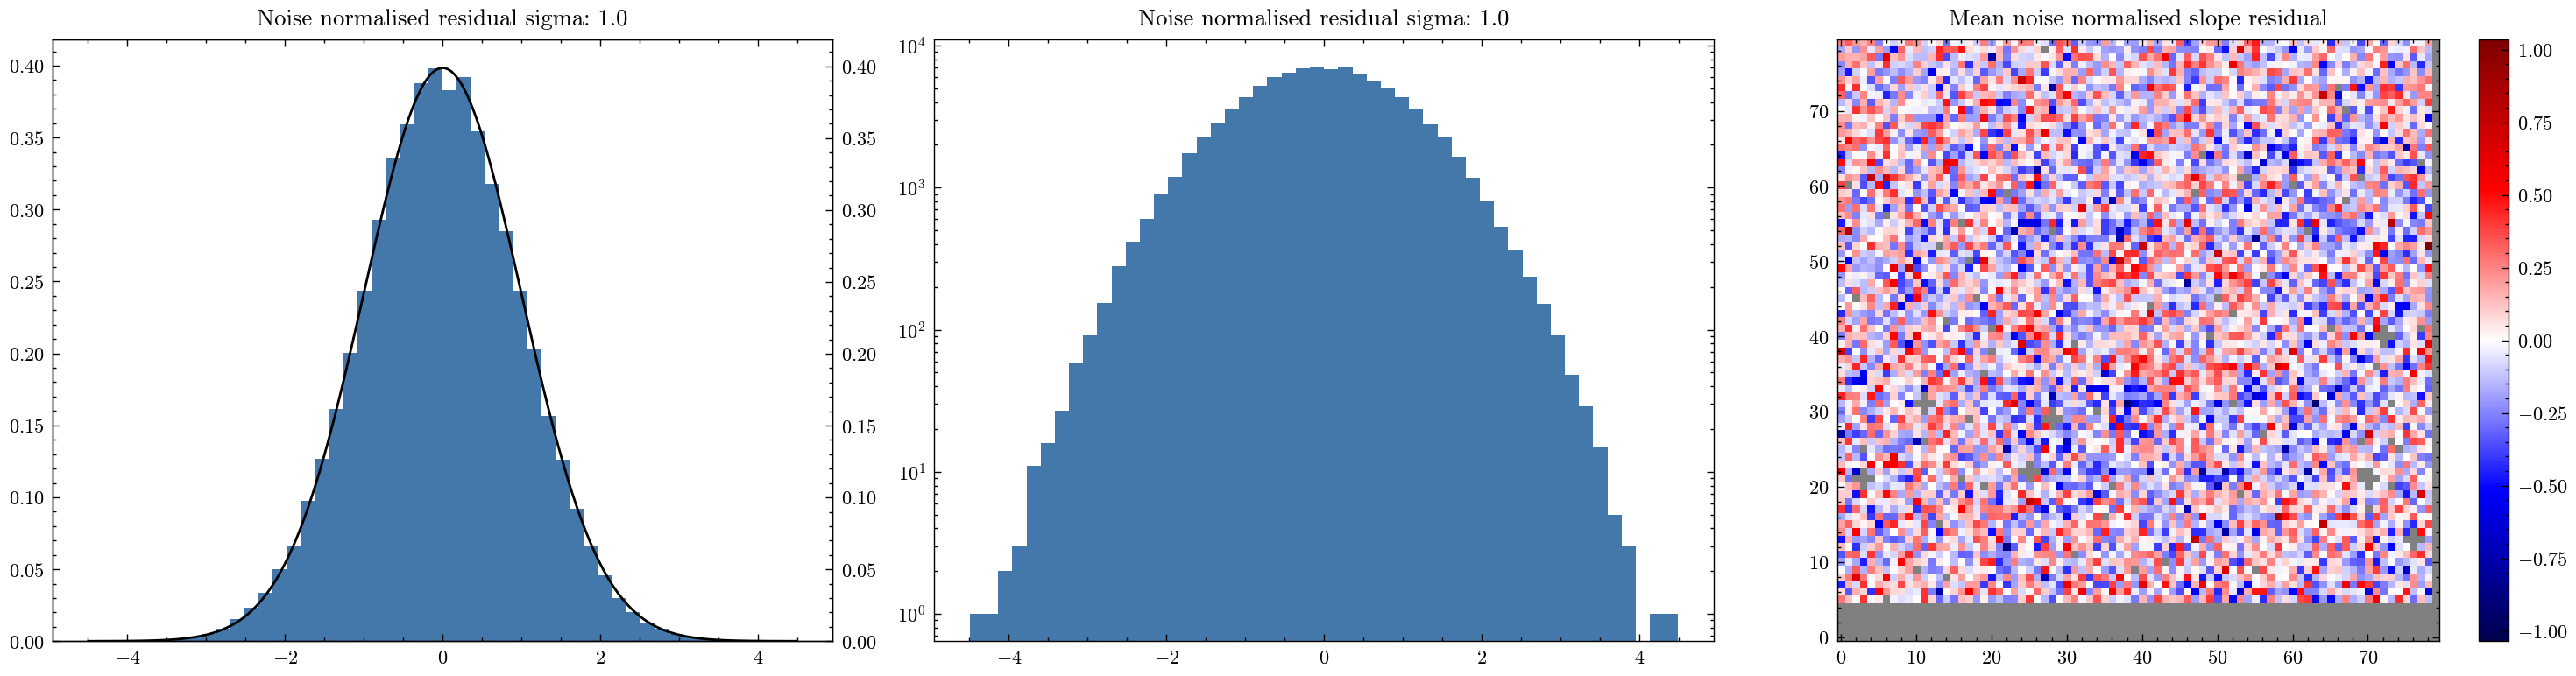

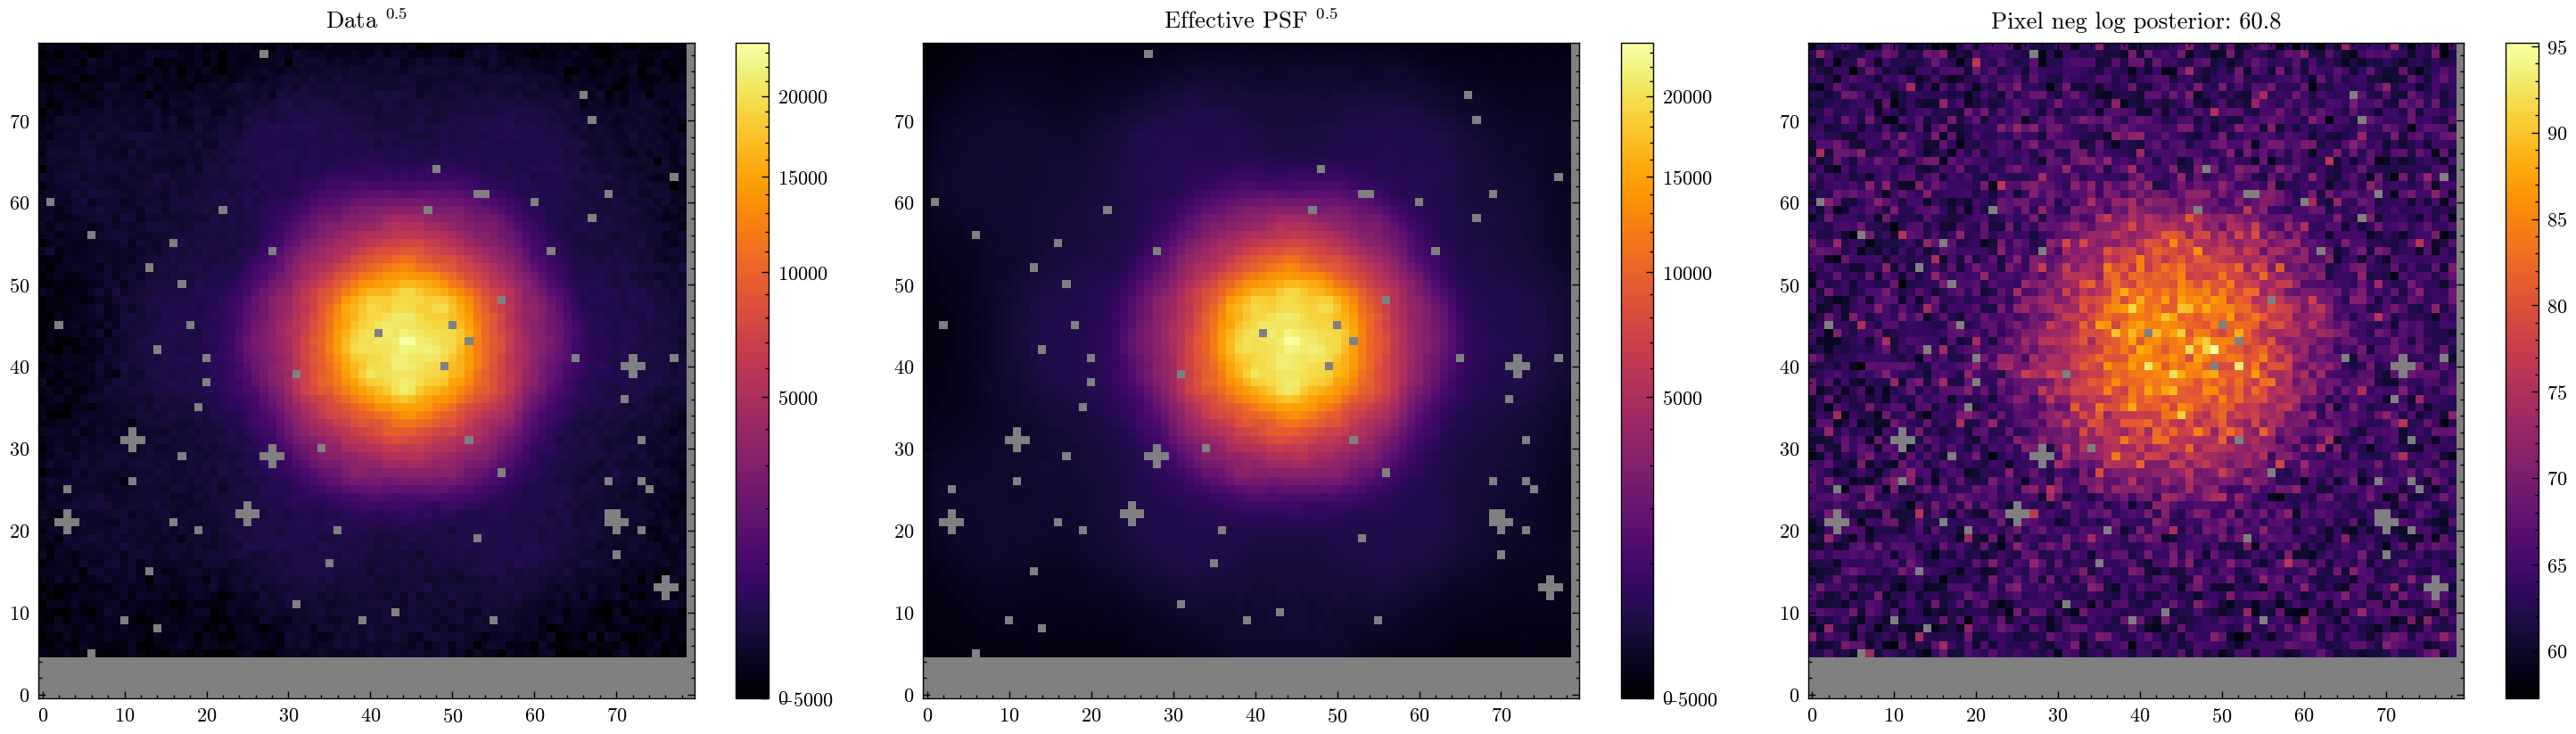

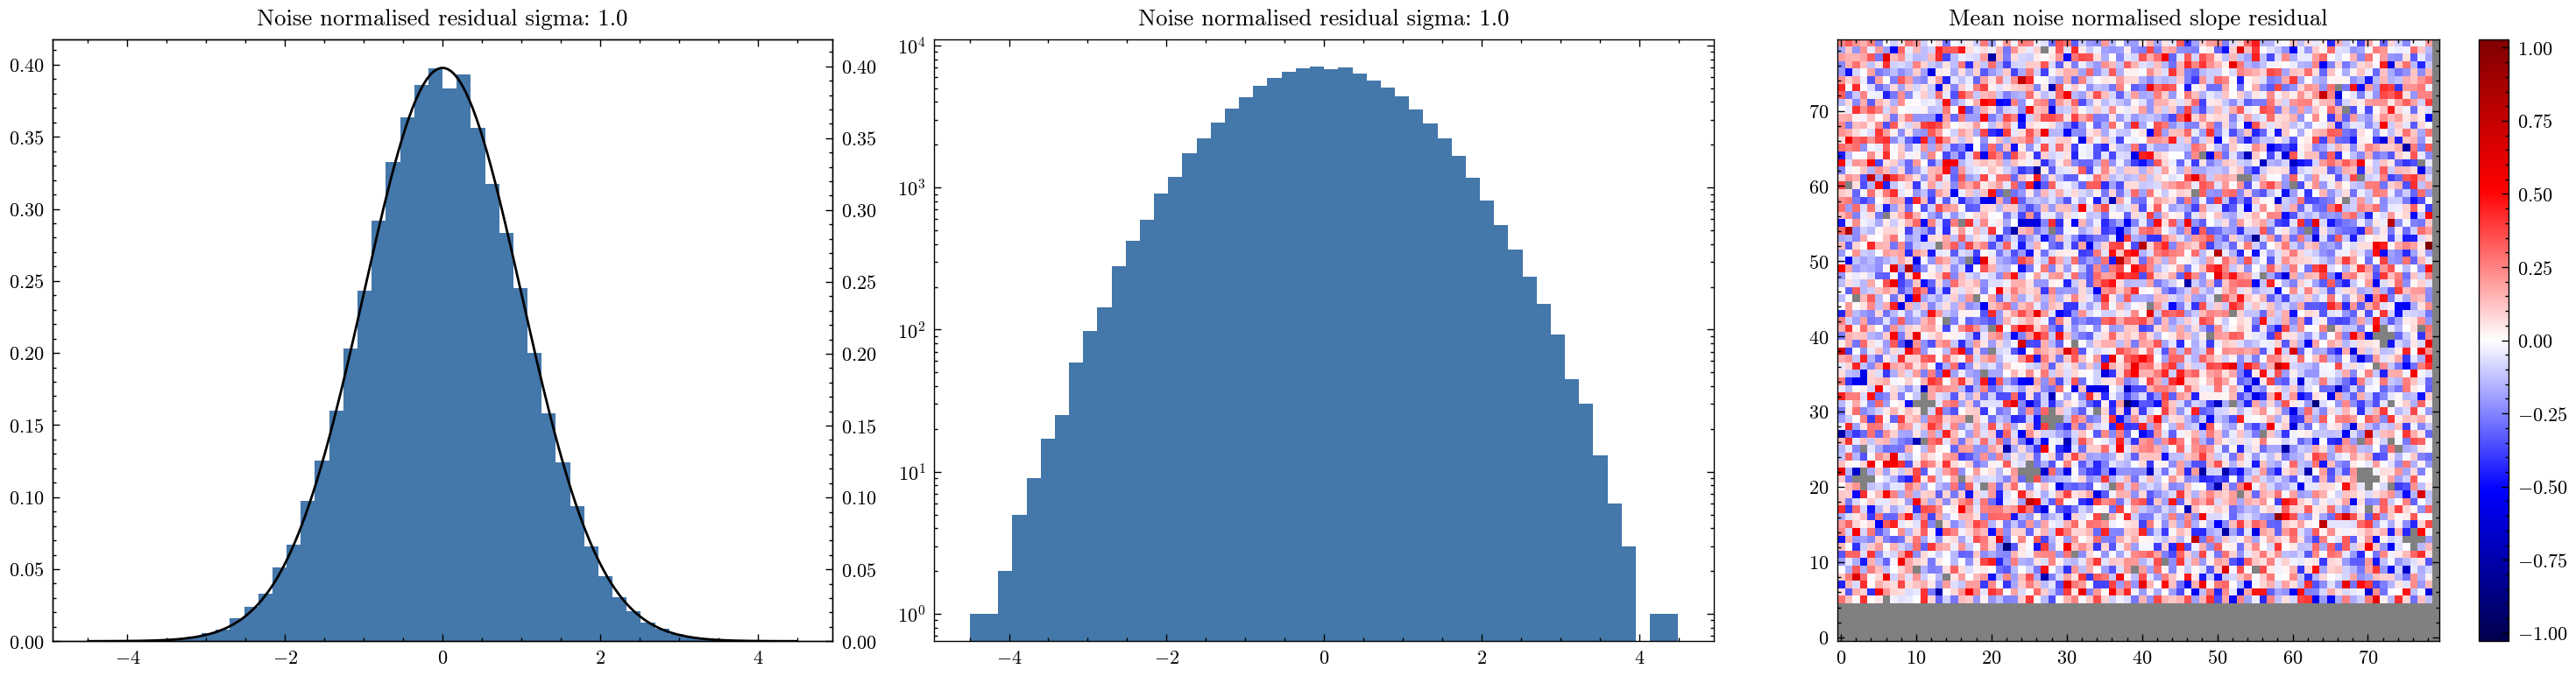

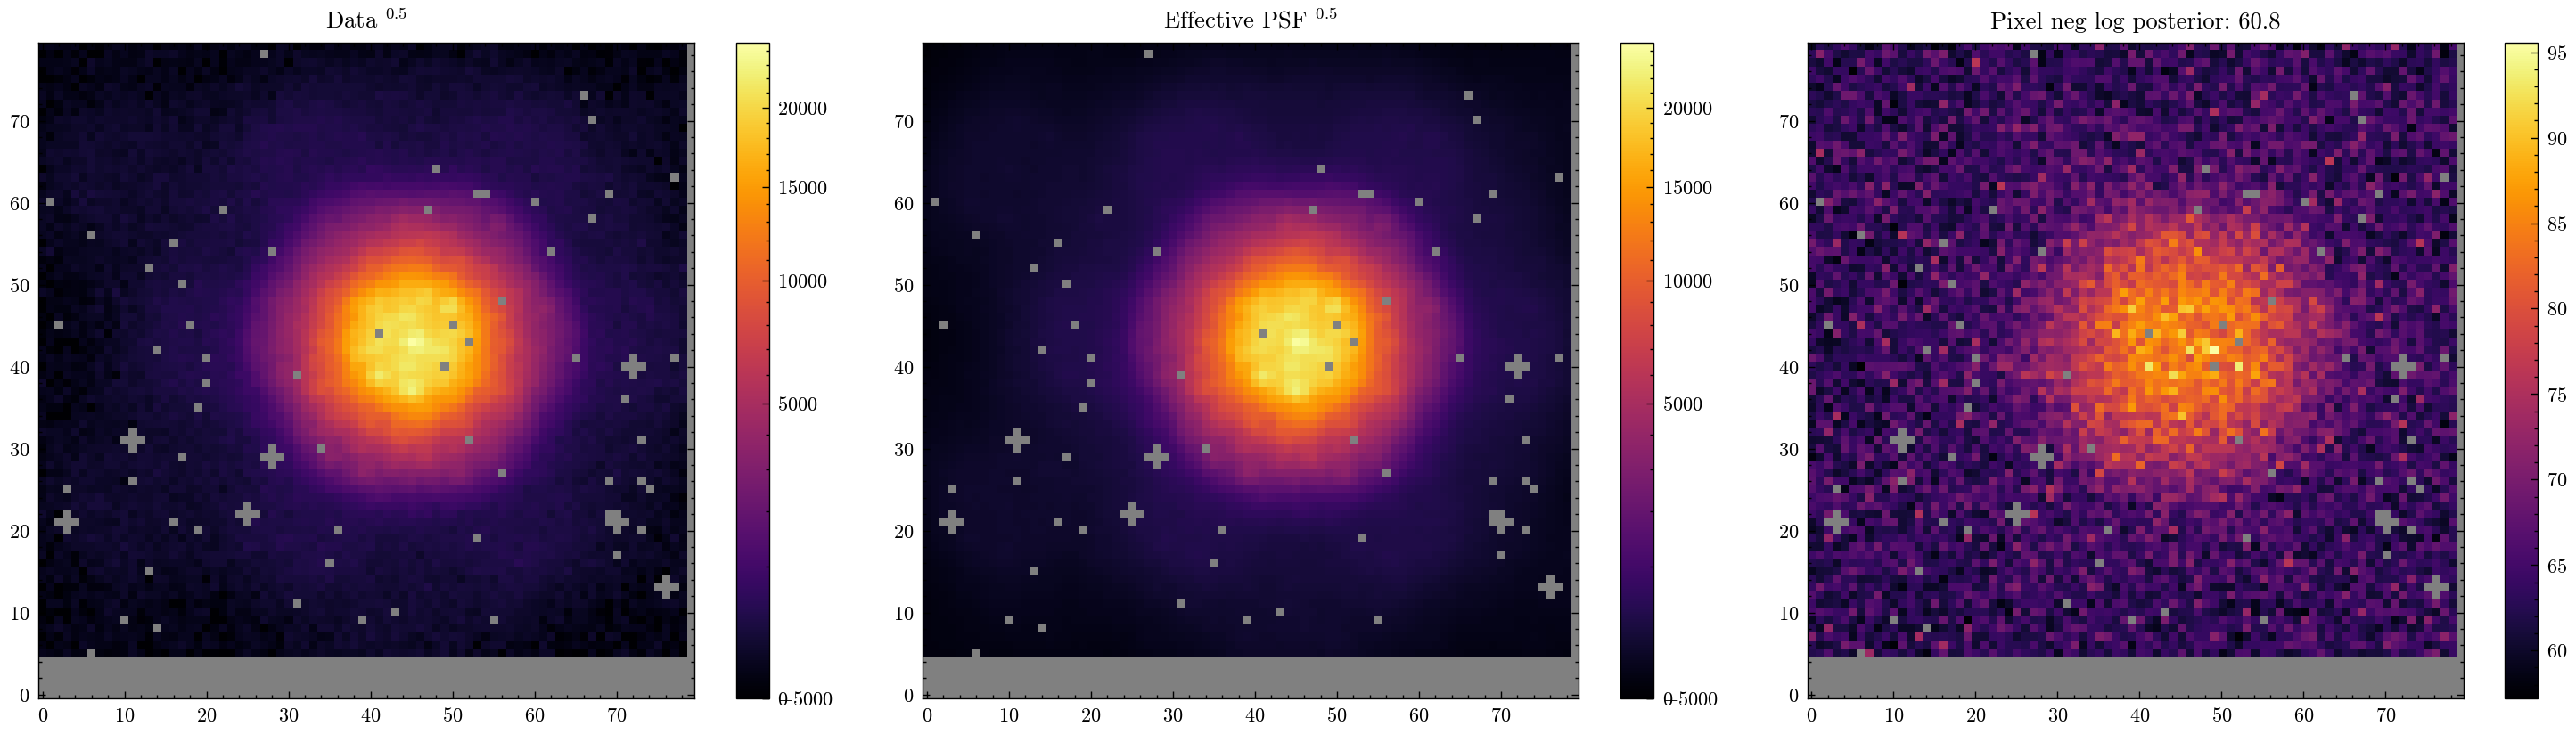

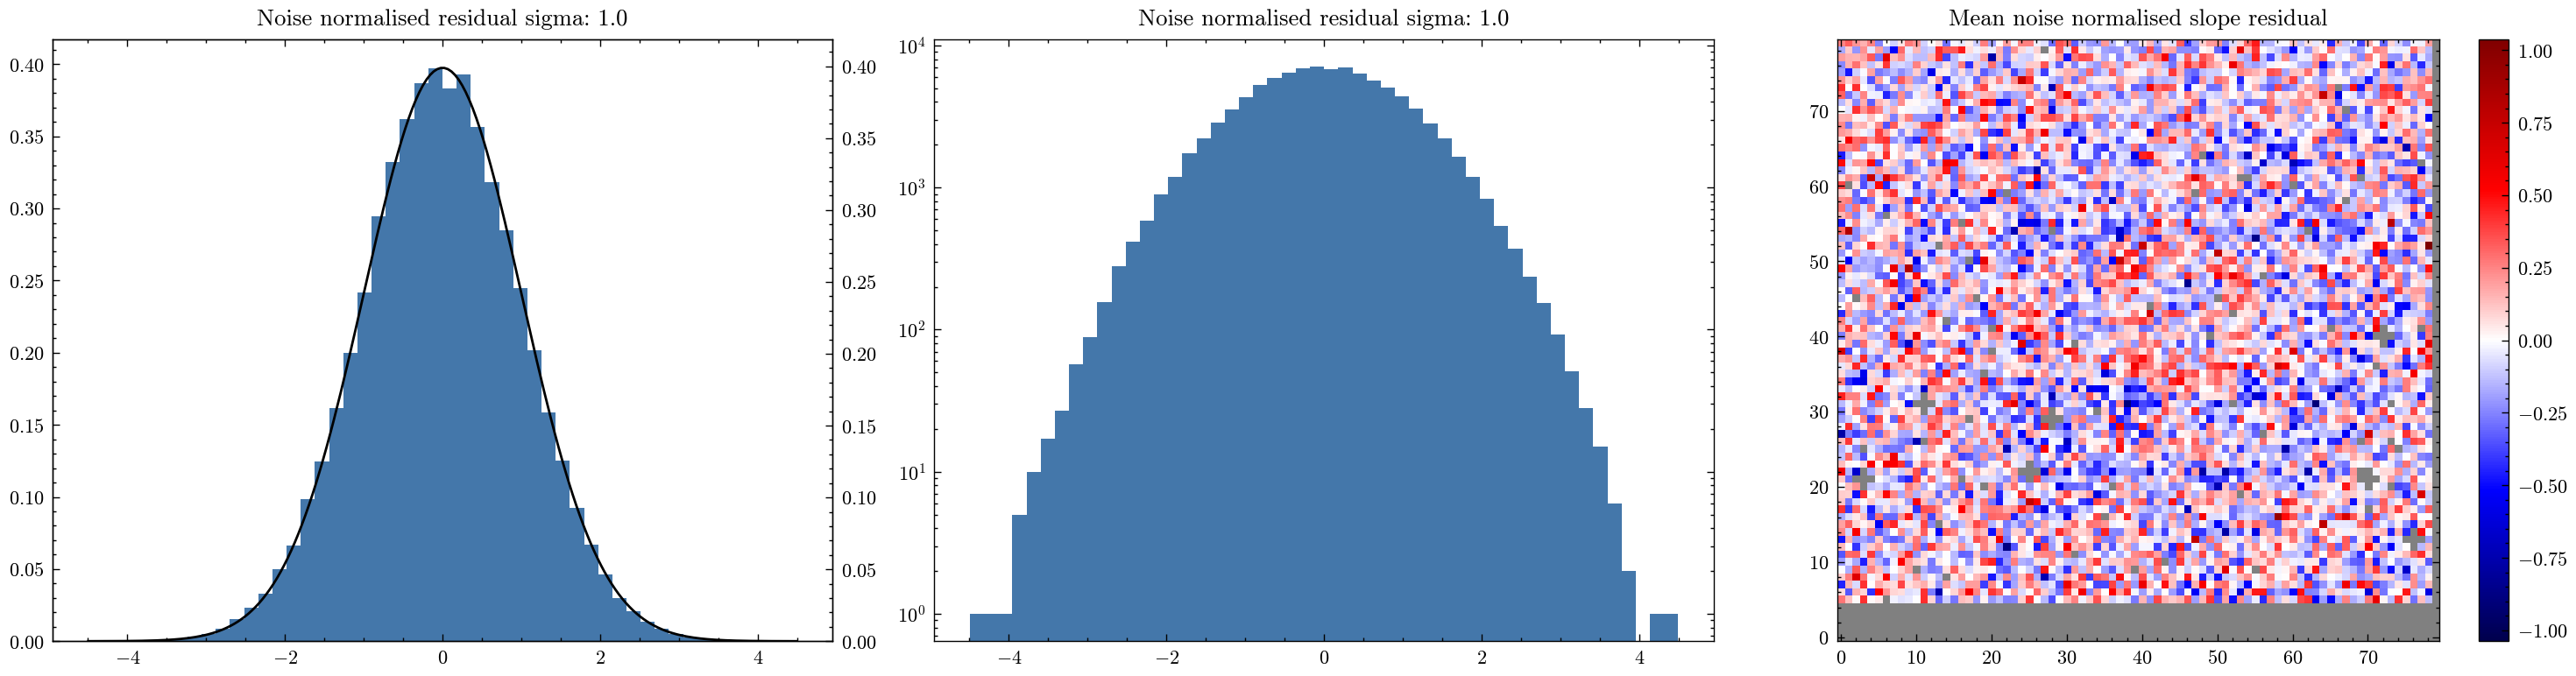

In [19]:
plot_losses(losses, start=int(n_epoch*0.75))
plot(histories[0])

for exp in exposures:
    # exp.print_summary()
    summarise_fit(
        exp,
        final_model,
        # test_model,
        residuals=True,
        histograms=True,
        # flat_field=True,
        # up_the_ramp=True,
        # up_the_ramp_norm=True,
        # full_bias=True,
        # aberrations=True,
    )

In [76]:
grid_len = 6
curve = np.linspace(0, 1, grid_len)**4
coeffs = {
    "L2": 2e6 * curve,
    "TV": 2e2 * curve,
    "QV": 1e7 * curve,
    "ME": 1e3 * curve,
}
reg_index = 5

chunks = [[{reg: float(coeff)} for coeff in coeffs[reg]] for reg in ["L2", "TV", "QV", "ME"]]
reg_dicts = []
for chunk in chunks:
    for reg_dict in chunk:
        reg_dicts.append(reg_dict)
reg_dict = reg_dicts[reg_index]
reg_key = list(reg_dict.keys())[0] + "_" + f"{list(reg_dict.values())[0]:.4e}"

args = {
    "reg_dict": reg_dict,
    "reg_func_dict": stats.reg_func_dict,
}

In [77]:
reg_dicts

[{'L2': 0.0},
 {'L2': 3200.0000000000014},
 {'L2': 51200.00000000002},
 {'L2': 259200.00000000015},
 {'L2': 819200.0000000003},
 {'L2': 2000000.0},
 {'TV': 0.0},
 {'TV': 0.3200000000000002},
 {'TV': 5.120000000000003},
 {'TV': 25.920000000000016},
 {'TV': 81.92000000000004},
 {'TV': 200.0},
 {'QV': 0.0},
 {'QV': 16000.000000000007},
 {'QV': 256000.00000000012},
 {'QV': 1296000.0000000007},
 {'QV': 4096000.000000002},
 {'QV': 10000000.0},
 {'ME': 0.0},
 {'ME': 1.6000000000000008},
 {'ME': 25.600000000000012},
 {'ME': 129.60000000000008},
 {'ME': 409.6000000000002},
 {'ME': 1000.0}]